## Text classification using Neural Networks

The goal of this notebook is to learn to use Neural Networks for text classification.

In this notebook, we will:
- Train a shallow model with learning embeddings
- Download pre-trained embeddings from Glove
- Use these pre-trained embeddings

However keep in mind:
- Deep Learning can be better on text classification that simpler ML techniques, but only on very large datasets and well designed/tuned models.
- The following projects can replicate similar word embedding models much more efficiently than we will do with PyTorch in this notebook: [word2vec](https://github.com/dav/word2vec) and [gensim's word2vec](https://radimrehurek.com/gensim/models/word2vec.html)   (self-supervised learning only), [fastText](https://github.com/facebookresearch/fastText) (both supervised and self-supervised learning), [Vowpal Wabbit](https://github.com/JohnLangford/vowpal_wabbit/wiki) (supervised learning).
- Plain shallow sparse TF-IDF bigrams features without any embedding and Logistic Regression or Multinomial Naive Bayes is often competitive in small to medium datasets.
- For prediction tasks that need to take the order of the words into account (to finally model the interplay of different words within each sentence), state of the art models use more complex models based on deeper transformers that will be presented in subsequent notebooks.


### 20 Newsgroups Dataset

The 20 Newsgroups data set is a collection of approximately 20,000 newsgroup documents, partitioned (nearly) evenly across 20 different newsgroups http://qwone.com/~jason/20Newsgroups/

In [1]:
import numpy as np
from sklearn.datasets import fetch_20newsgroups

newsgroups_train = fetch_20newsgroups(subset='train')
newsgroups_test = fetch_20newsgroups(subset='test')

In [2]:
sample_idx = 1000
print(newsgroups_train["data"][sample_idx])

From: dabl2@nlm.nih.gov (Don A.B. Lindbergh)
Subject: Diamond SS24X, Win 3.1, Mouse cursor
Organization: National Library of Medicine
Lines: 10


Anybody seen mouse cursor distortion running the Diamond 1024x768x256 driver?
Sorry, don't know the version of the driver (no indication in the menus) but it's a recently
delivered Gateway system.  Am going to try the latest drivers from Diamond BBS but wondered
if anyone else had seen this.

post or email

--Don Lindbergh
dabl2@lhc.nlm.nih.gov



In [3]:
target_names = newsgroups_train["target_names"]

target_id = newsgroups_train["target"][sample_idx]
print("Class of previous message:", target_names[target_id])

Class of previous message: comp.os.ms-windows.misc


Here are all the possible classes:

In [4]:
target_names

['alt.atheism',
 'comp.graphics',
 'comp.os.ms-windows.misc',
 'comp.sys.ibm.pc.hardware',
 'comp.sys.mac.hardware',
 'comp.windows.x',
 'misc.forsale',
 'rec.autos',
 'rec.motorcycles',
 'rec.sport.baseball',
 'rec.sport.hockey',
 'sci.crypt',
 'sci.electronics',
 'sci.med',
 'sci.space',
 'soc.religion.christian',
 'talk.politics.guns',
 'talk.politics.mideast',
 'talk.politics.misc',
 'talk.religion.misc']

In [5]:
newsgroups_train["data"][0]

"From: lerxst@wam.umd.edu (where's my thing)\nSubject: WHAT car is this!?\nNntp-Posting-Host: rac3.wam.umd.edu\nOrganization: University of Maryland, College Park\nLines: 15\n\n I was wondering if anyone out there could enlighten me on this car I saw\nthe other day. It was a 2-door sports car, looked to be from the late 60s/\nearly 70s. It was called a Bricklin. The doors were really small. In addition,\nthe front bumper was separate from the rest of the body. This is \nall I know. If anyone can tellme a model name, engine specs, years\nof production, where this car is made, history, or whatever info you\nhave on this funky looking car, please e-mail.\n\nThanks,\n- IL\n   ---- brought to you by your neighborhood Lerxst ----\n\n\n\n\n"

### Preprocessing text for the (supervised) CBOW model

We will implement a simple classification model with PyTorch. Raw text requires (sometimes a lot of) preprocessing.

The following cells uses PyTorch to preprocess text:
- using a tokenizer. You may use different tokenizers (from scikit-learn, NLTK, custom Python function etc.). This converts the texts into sequences of indices representing the `20000` most frequent words
- sequences have different lengths, so we pad them (add 0s at the end until the sequence is of length `1000`)
- we convert the output classes as 1-hot encodings

In [6]:
from torchtext.data.utils import get_tokenizer
from torchtext.vocab import build_vocab_from_iterator

# Get the raw text data.
texts_train = newsgroups_train["data"]
texts_test = newsgroups_test["data"]

tokenizer = get_tokenizer('basic_english')

In [7]:
tokenizer(newsgroups_train["data"][0])

['from',
 'lerxst@wam',
 '.',
 'umd',
 '.',
 'edu',
 '(',
 'where',
 "'",
 's',
 'my',
 'thing',
 ')',
 'subject',
 'what',
 'car',
 'is',
 'this',
 '!',
 '?',
 'nntp-posting-host',
 'rac3',
 '.',
 'wam',
 '.',
 'umd',
 '.',
 'edu',
 'organization',
 'university',
 'of',
 'maryland',
 ',',
 'college',
 'park',
 'lines',
 '15',
 'i',
 'was',
 'wondering',
 'if',
 'anyone',
 'out',
 'there',
 'could',
 'enlighten',
 'me',
 'on',
 'this',
 'car',
 'i',
 'saw',
 'the',
 'other',
 'day',
 '.',
 'it',
 'was',
 'a',
 '2-door',
 'sports',
 'car',
 ',',
 'looked',
 'to',
 'be',
 'from',
 'the',
 'late',
 '60s/',
 'early',
 '70s',
 '.',
 'it',
 'was',
 'called',
 'a',
 'bricklin',
 '.',
 'the',
 'doors',
 'were',
 'really',
 'small',
 '.',
 'in',
 'addition',
 ',',
 'the',
 'front',
 'bumper',
 'was',
 'separate',
 'from',
 'the',
 'rest',
 'of',
 'the',
 'body',
 '.',
 'this',
 'is',
 'all',
 'i',
 'know',
 '.',
 'if',
 'anyone',
 'can',
 'tellme',
 'a',
 'model',
 'name',
 ',',
 'engine',
 'sp

Let's now tokenize all documents in the dataset to build a vocabulary with the set of all unique token that appear at least `min_freq` times in the whole `texts_train` dataset:

In [8]:
def yield_tokens(data_iter):
    for text in data_iter:
        yield tokenizer(text)


vocab = build_vocab_from_iterator(
    yield_tokens(texts_train),
    specials=["<unk>"],
    min_freq=5,  # ignore words that appear fewer than 5 times
)
vocab.set_default_index(vocab["<unk>"])

# Re-execute this cell with different values of min_freq to see
# the impact on the size of the resulting vocabulary:
print(f"Vocabulary size: {len(vocab)} unique tokens.")

Vocabulary size: 32964 unique tokens.


Tokenized sequences are converted to list of token ids (with an integer code):

In [9]:
def text_to_token_ids(text):
    return vocab(tokenizer(text))


text_to_token_ids(texts_train[0])

[22,
 0,
 1,
 1297,
 1,
 30,
 7,
 145,
 4,
 25,
 52,
 245,
 6,
 39,
 50,
 294,
 14,
 24,
 21,
 16,
 96,
 24751,
 1,
 7637,
 1,
 1297,
 1,
 30,
 42,
 85,
 8,
 2806,
 2,
 605,
 1748,
 40,
 266,
 12,
 35,
 1301,
 36,
 157,
 76,
 51,
 118,
 9414,
 71,
 23,
 24,
 294,
 12,
 689,
 3,
 90,
 278,
 1,
 17,
 35,
 10,
 28921,
 2282,
 294,
 2,
 1126,
 5,
 26,
 22,
 3,
 1341,
 0,
 823,
 9309,
 1,
 17,
 35,
 353,
 10,
 0,
 1,
 3,
 3998,
 89,
 173,
 501,
 1,
 13,
 1322,
 2,
 3,
 852,
 7863,
 35,
 1760,
 22,
 3,
 800,
 8,
 3,
 756,
 1,
 24,
 14,
 56,
 12,
 91,
 1,
 36,
 157,
 43,
 0,
 10,
 872,
 303,
 2,
 1064,
 2789,
 2,
 189,
 8,
 2870,
 2,
 145,
 24,
 294,
 14,
 235,
 2,
 617,
 2,
 34,
 808,
 411,
 20,
 29,
 23,
 24,
 24023,
 381,
 294,
 2,
 171,
 441,
 1,
 215,
 2,
 41,
 1541,
 975,
 1298,
 5,
 20,
 44,
 64,
 7751,
 0,
 975]

The tokenizer object stores a mapping (vocabulary) from word strings to token ids that can be inverted:

In [10]:
vocab.lookup_tokens([22, 0, 1, 1297])

['from', '<unk>', '.', 'umd']

We can use this inverse mapping to reconstruct the original message (without formatting):

In [11]:
def token_ids_to_text(token_ids):
    return " ".join(vocab.lookup_tokens(token_ids))


token_ids_to_text(text_to_token_ids(texts_train[0]))

"from <unk> . umd . edu ( where ' s my thing ) subject what car is this ! ? nntp-posting-host rac3 . wam . umd . edu organization university of maryland , college park lines 15 i was wondering if anyone out there could enlighten me on this car i saw the other day . it was a 2-door sports car , looked to be from the late <unk> early 70s . it was called a <unk> . the doors were really small . in addition , the front bumper was separate from the rest of the body . this is all i know . if anyone can <unk> a model name , engine specs , years of production , where this car is made , history , or whatever info you have on this funky looking car , please e-mail . thanks , - il ---- brought to you by your neighborhood <unk> ----"

Observe that it's not possible to reconstruct the original text exactly. Some details have been lost in the tokenization-detokenization round trip. In particular, in frequent names have been replaced by the `<unk>` token:

In [12]:
texts_train[0]

"From: lerxst@wam.umd.edu (where's my thing)\nSubject: WHAT car is this!?\nNntp-Posting-Host: rac3.wam.umd.edu\nOrganization: University of Maryland, College Park\nLines: 15\n\n I was wondering if anyone out there could enlighten me on this car I saw\nthe other day. It was a 2-door sports car, looked to be from the late 60s/\nearly 70s. It was called a Bricklin. The doors were really small. In addition,\nthe front bumper was separate from the rest of the body. This is \nall I know. If anyone can tellme a model name, engine specs, years\nof production, where this car is made, history, or whatever info you\nhave on this funky looking car, please e-mail.\n\nThanks,\n- IL\n   ---- brought to you by your neighborhood Lerxst ----\n\n\n\n\n"

Let's have a closer look at the tokenized sequences:

In [13]:
sequences = [text_to_token_ids(item) for item in texts_train]
sequences[0][:10]

[22, 0, 1, 1297, 1, 30, 7, 145, 4, 25]

In [14]:
sequences_test = [text_to_token_ids(item) for item in texts_test]
sequences_test[0][:10]

[22, 0, 1, 285, 1, 1226, 1, 30, 7, 4810]

In [15]:
seq_lens = [len(s) for s in sequences]
print("average length: %0.1f" % np.mean(seq_lens))
print("max length: %d" % max(seq_lens))

average length: 393.2
max length: 26314


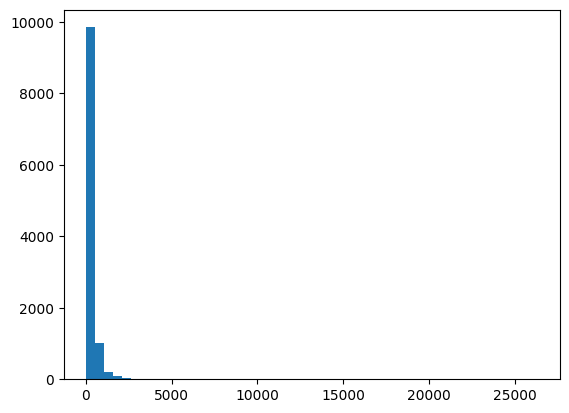

In [16]:
%matplotlib inline
import matplotlib.pyplot as plt

plt.hist(seq_lens, bins=50);

Let's zoom on the distribution of regular sized posts. The vast majority of the posts have less than 1000 symbols:

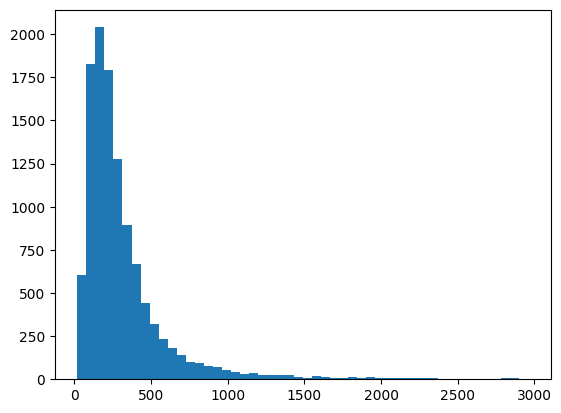

In [17]:
plt.hist([l for l in seq_lens if l < 3000], bins=50);

Let's truncate and pad all the sequences to 1000 symbols to build the training set:

In [18]:
def pad_sequences(sequences, maxlen=1000):
    padded = np.zeros(shape=(len(sequences), maxlen), dtype=np.int32)
    for i, seq in enumerate(sequences):
        seq = seq[:maxlen]
        padded[i, 0:len(seq)] = seq
    return padded


# Pad sequences with 0s.
x_train = pad_sequences(sequences)
x_test = pad_sequences(sequences_test)

print('Shape of data tensor:', x_train.shape)
print('Shape of data test tensor:', x_test.shape)

Shape of data tensor: (11314, 1000)
Shape of data test tensor: (7532, 1000)


In [19]:
y_train = newsgroups_train["target"]
y_test = newsgroups_test["target"]

### A simple supervised CBOW model in PyTorch
















The following computes a very simple model, as described in [fastText](https://github.com/facebookresearch/fastText):

<img src="https://raw.githubusercontent.com/m2dsupsdlclass/lectures-labs/6ccf141172e47a3d9e367620b4d70e1c9564e9d2/labs/06_deep_nlp/images/fasttext.svg" style="width: 600px;" />

- Build an embedding layer mapping each word to a vector representation
- Compute the vector representation of all words in each sequence and average them
- Add a dense layer to output 20 classes (+ softmax)

In [20]:
%pip install -q torchmetrics

In [21]:
import torch
import torch.nn as nn

from tqdm.notebook import tqdm
from torchmetrics import Accuracy
from torch.utils.data import DataLoader

DEVICE = torch.device("cuda") if torch.cuda.is_available() else torch.device("cpu")
DEVICE

device(type='cuda')

In [22]:
EMBEDDING_DIM = 50
N_CLASSES = len(target_names)

class TextClassificationModel(nn.Module):

    def __init__(
        self,
        vocab_size,
        embed_dim,
        num_class,
        pretrained_embedding=None
    ):
        super(TextClassificationModel, self).__init__()
        if pretrained_embedding is not None:
            # If we use use pretrained.
            self.embedding = pretrained_embedding
            self.embedding.weight.requires_grad = False # Freeze embeddings.
        else:
            self.embedding = nn.EmbeddingBag(vocab_size, embed_dim, mode="mean")
        self.fc = nn.Linear(embed_dim, num_class)

    def forward(self, text):
        embedded = self.embedding(text)
        out = self.fc(embedded)
        return out


model = TextClassificationModel(
    vocab_size=len(vocab), embed_dim=EMBEDDING_DIM, num_class=N_CLASSES
)

In [23]:
train_data = []
for i in range(len(x_train)):
    train_data.append([x_train[i], y_train[i]])

test_data = []
for i in range(len(x_test)):
    test_data.append([x_test[i], y_test[i]])


train_dl = DataLoader(train_data, batch_size=256, shuffle=True)
test_dl = DataLoader(test_data, batch_size=256, shuffle=True)

In [24]:
def train_model(model, n_epochs=30, lr=1e-2, weight_decay=0.):
    optimizer = torch.optim.Adam(
        params=model.parameters(),
        lr=lr,
        weight_decay=weight_decay,
    )
    criterion = torch.nn.CrossEntropyLoss()

    model.to(DEVICE)

    pbar = tqdm(range(n_epochs))

    val_acc = Accuracy("multiclass", num_classes=N_CLASSES).to(DEVICE)
    train_acc = Accuracy("multiclass", num_classes=N_CLASSES).to(DEVICE)

    for epoch in pbar:
        model.train()
        for batch in train_dl:
            x, y = batch
            x = x.to(DEVICE)
            y = y.to(DEVICE)

            preds = model(x)

            loss = criterion(preds, y)
            train_acc.update(preds, y)


            loss.backward()
            optimizer.step()
            optimizer.zero_grad()

        epoch_train_acc = train_acc.compute()
        train_acc.reset()


        model.eval()
        with torch.no_grad():
            for batch in test_dl:
                x, y = batch
                x = x.to(DEVICE)
                y = y.to(DEVICE)

                val_acc.update(model(x), y)

            epoch_val_acc = val_acc.compute()

            val_acc.reset()

        pbar.set_description(
            f"Epoch {epoch}, Train loss : {loss.item():.4f}, "
            f"Val acc: {epoch_val_acc.item():.2f}, "
            f"Train acc: {epoch_train_acc.item():.2f}"
        )


train_model(model)

  0%|          | 0/30 [00:00<?, ?it/s]

### Building more complex models

The following exercise gives you an opportunity to train deeper models with more complex layers that attempt to leverage the word ordering in their internal representations of the documents to classifier.

**Bonus exercise**
- From the previous template, build more complex models using:
  - 1d convolution and 1d maxpooling.
  - If you are already familliar with recurrent neural networks, you can try to combinar LSTM layers on convolutional layers (you will need to reduce sequence length with max pooling or strided convolutions before though).
  
<img src="https://raw.githubusercontent.com/m2dsupsdlclass/lectures-labs/6ccf141172e47a3d9e367620b4d70e1c9564e9d2/labs/06_deep_nlp/images/
unrolled_rnn_one_output_2.svg" style="width: 600px;" />

**WARNING**: Do not waste too much effort on this though. It's likely that our baseline model will be hard to beat.

Note: The goal is to build working models rather than getting better test accuracy. To achieve much better results, we'd need more computation time and data quantity. Build your model, and verify that the training loss decreases for a few epochs and feel free to interrupt.

## Solution: a convolutional model!

In [27]:
EMBEDDING_DIM = 50
N_CLASSES = len(target_names)

class ConvTextClassificationModel(nn.Module):

    def __init__(self, vocab_size, embed_dim, num_class, embedding=None):
        super(ConvTextClassificationModel, self).__init__()

        if embedding:
            # If we use use pretrained.
            self.embedding = embedding
            self.embeddings.weight.requires_grad = False # Freeze embeddings.
        else:
            self.embedding = nn.Embedding(vocab_size, embed_dim)

        self.conv1 = nn.Sequential(
            nn.Conv1d(in_channels=50, out_channels=64, kernel_size=5),
            nn.MaxPool1d(5),
            nn.Dropout(p=0.2),
            nn.ReLU()
        )

        self.conv2 = nn.Sequential(
            nn.Conv1d(in_channels=64, out_channels=64, kernel_size=5),
            nn.MaxPool1d(5),
            nn.Dropout(p=0.2),
            nn.ReLU()
        )

        self.fc = nn.Sequential(nn.Flatten(), nn.ReLU(), nn.Dropout(p=0.2), nn.Linear(64*39, num_class))

    def forward(self, text):
        x = self.embedding(text)
        x = x.transpose(1, 2) # To have the proper representation for 1d convs.
        x = self.conv1(x)
        x = self.conv2(x)
        out = self.fc(x)
        return out

model = ConvTextClassificationModel(vocab_size=len(vocab), embed_dim=EMBEDDING_DIM, num_class=N_CLASSES)

This model is very slow to train and does not reach an accuracy that is better than our simple EmbeddingBag averaging model:

In [28]:
# train_model(model, n_epochs=100, lr=1e-3, weight_decay=1e-6)

### Solution: an LSTM model!

In [ ]:
EMBEDDING_DIM = 50
N_CLASSES = len(target_names)

class LstmTextClassificationModel(nn.Module):

    def __init__(
        self,
        vocab_size,
        embed_dim,
        num_class,
        pretrained_embedding=None,
    ):
        super().__init__()

        if pretrained_embedding is not None:
            # If we use use pretrained.
            self.embedding = pretrained_embedding
            self.embeddings.weight.requires_grad = False # Freeze embeddings.
        else:
            self.embedding = nn.Embedding(vocab_size, embed_dim)

        self.conv1 = nn.Sequential(
            nn.Conv1d(in_channels=50, out_channels=64, kernel_size=5),
            nn.MaxPool1d(5),
            nn.Dropout(p=0.5),
            nn.ReLU()
        )

        self.conv2 = nn.Sequential(
            nn.Conv1d(in_channels=64, out_channels=64, kernel_size=5),
            nn.MaxPool1d(5),
            nn.Dropout(p=0.5),
            nn.ReLU()
        )

        self.lstm = nn.Sequential(
            nn.LSTM(input_size=64, hidden_size=64, num_layers=1, batch_first=True),
        )

        self.fc = nn.Sequential(nn.ReLU(), nn.Dropout(p=0.5), nn.Linear(64, num_class))

    def forward(self, text):
        x = self.embedding(text)
        x = x.transpose(1, 2) # To have the proper representation for 1d convs.
        x = self.conv1(x)
        x = self.conv2(x)
        x = x.transpose(1, 2)
        x, (ht, ct) = self.lstm(x)
        out = self.fc(ht.reshape(x.shape[0], -1)) # Use the last hidden layer.
        return out

model = LstmTextClassificationModel(
    vocab_size=len(vocab),
    embed_dim=EMBEDDING_DIM,
    num_class=N_CLASSES,
)

This model is very slow to train and does not reach an accuracy that is better than our simple EmbeddingBag averaging model:

In [ ]:
# train_model(model, n_epochs=300, lr=1e-3, weight_decay=1e-4)

### Loading pre-trained embeddings

The file `glove100K.100d.txt` is an extract of [Glove](http://nlp.stanford.edu/projects/glove/) Vectors, that were trained on english Wikipedia 2014 + Gigaword 5 (6B tokens).

We extracted the `100 000` most frequent words. They have a dimension of `100`

In [29]:
import os

import zipfile
from urllib.request import urlretrieve

Downloading and extracting gloves embeddings :

In [30]:
URL_REPRESENTATIONS = "https://github.com/m2dsupsdlclass/lectures-labs/releases/download/0.3/glove100k.100d.zip"
ZIP_REPRESENTATIONS = "glove100k.100d.zip"
FILE_REPRESENTATIONS = "glove100K.100d.txt"

print('Downloading from %s to %s...' % (URL_REPRESENTATIONS, ZIP_REPRESENTATIONS))
urlretrieve(URL_REPRESENTATIONS, './' + ZIP_REPRESENTATIONS)

print("extracting %s..." % ZIP_REPRESENTATIONS)
myzip = zipfile.ZipFile(ZIP_REPRESENTATIONS)
myzip.extractall()

extracting glove100k.100d.zip...


In [31]:
embeddings_index = {}
embeddings_vectors = []
f = open('glove100K.100d.txt', 'rb')

word_idx = 0
for line in f:
    values = line.decode('utf-8').split()
    word = values[0]
    vector = np.asarray(values[1:], dtype='float32')
    embeddings_index[word] = word_idx
    embeddings_vectors.append(vector)
    word_idx = word_idx + 1
f.close()

inv_index = {v: k for k, v in embeddings_index.items()}
print("found %d different words in the file" % word_idx)

found 100000 different words in the file


In [32]:
# Stack all embeddings in a large numpy array
glove_embeddings = np.vstack(embeddings_vectors)
glove_norms = np.linalg.norm(glove_embeddings, axis=-1, keepdims=True)
glove_embeddings_normed = glove_embeddings / glove_norms
print(glove_embeddings.shape)

(100000, 100)


In [33]:
def get_emb(word):
    idx = embeddings_index.get(word)
    if idx is None:
        return None
    else:
        return glove_embeddings[idx]


def get_normed_emb(word):
    idx = embeddings_index.get(word)
    if idx is None:
        return None
    else:
        return glove_embeddings_normed[idx]

In [34]:
get_emb("computer")

array([-1.6298e-01,  3.0141e-01,  5.7978e-01,  6.6548e-02,  4.5835e-01,
       -1.5329e-01,  4.3258e-01, -8.9215e-01,  5.7747e-01,  3.6375e-01,
        5.6524e-01, -5.6281e-01,  3.5659e-01, -3.6096e-01, -9.9662e-02,
        5.2753e-01,  3.8839e-01,  9.6185e-01,  1.8841e-01,  3.0741e-01,
       -8.7842e-01, -3.2442e-01,  1.1202e+00,  7.5126e-02,  4.2661e-01,
       -6.0651e-01, -1.3893e-01,  4.7862e-02, -4.5158e-01,  9.3723e-02,
        1.7463e-01,  1.0962e+00, -1.0044e+00,  6.3889e-02,  3.8002e-01,
        2.1109e-01, -6.6247e-01, -4.0736e-01,  8.9442e-01, -6.0974e-01,
       -1.8577e-01, -1.9913e-01, -6.9226e-01, -3.1806e-01, -7.8565e-01,
        2.3831e-01,  1.2992e-01,  8.7721e-02,  4.3205e-01, -2.2662e-01,
        3.1549e-01, -3.1748e-01, -2.4632e-03,  1.6615e-01,  4.2358e-01,
       -1.8087e+00, -3.6699e-01,  2.3949e-01,  2.5458e+00,  3.6111e-01,
        3.9486e-02,  4.8607e-01, -3.6974e-01,  5.7282e-02, -4.9317e-01,
        2.2765e-01,  7.9966e-01,  2.1428e-01,  6.9811e-01,  1.12

### Finding most similar words

**Exercice**

Build a function to find most similar words, given a word as query:
- lookup the vector for the query word in the Glove index;
- compute the cosine similarity between a word embedding and all other words;
- display the top 10 most similar words.

**Bonus**

Change your function so that it takes multiple words as input (by averaging them)

In [35]:
def most_similar(words, topn=10):





    return []  # write me!







### Solution

In [36]:
def most_similar(words, topn=10):
    query_emb = 0
    # If we have a list of words instead of one word
    # (bonus question)
    if type(words) == list:
        for word in words:
            query_emb += get_emb(word)
    else:
        query_emb = get_emb(words)

    query_emb = query_emb / np.linalg.norm(query_emb)

    # Large numpy vector with all cosine similarities
    # between emb and all other words
    cosines = np.dot(glove_embeddings_normed, query_emb)

    # topn most similar indexes corresponding to cosines
    idxs = np.argsort(cosines)[::-1][:topn]

    # pretty return with word and similarity
    return [(inv_index[idx], cosines[idx]) for idx in idxs]

In [37]:
most_similar("cpu")

[('cpu', 0.99999994),
 ('processor', 0.77934384),
 ('cpus', 0.7651844),
 ('microprocessor', 0.73606336),
 ('processors', 0.67348146),
 ('motherboard', 0.66757727),
 ('x86', 0.6655922),
 ('pentium', 0.64758503),
 ('gpu', 0.6448882),
 ('i/o', 0.63523525)]

In [38]:
most_similar("pitt")

[('pitt', 0.9999999),
 ('angelina', 0.6750643),
 ('jolie', 0.65090513),
 ('parker', 0.60754234),
 ('clooney', 0.5999419),
 ('brad', 0.59897137),
 ('thornton', 0.59552884),
 ('aniston', 0.59510386),
 ("o'donnell", 0.5609595),
 ('willis', 0.55930793)]

In [39]:
most_similar("jolie")

[('jolie', 0.99999994),
 ('angelina', 0.90007746),
 ('pitt', 0.650905),
 ('aniston', 0.6412107),
 ('changeling', 0.61878836),
 ('neeson', 0.6049725),
 ('kidman', 0.58190113),
 ('blanchett', 0.5802767),
 ('fonda', 0.5747691),
 ('clooney', 0.56517184)]

Predict the future better than tarot:

In [40]:
np.dot(get_normed_emb('aniston'), get_normed_emb('pitt'))

0.5951038

In [41]:
np.dot(get_normed_emb('jolie'), get_normed_emb('pitt'))

0.6509051

In [42]:
most_similar("1")

[('1', 1.0000001),
 ('2', 0.97136045),
 ('3', 0.9551016),
 ('4', 0.93552566),
 ('5', 0.9143885),
 ('6', 0.90160364),
 ('8', 0.8834145),
 ('7', 0.87454295),
 ('9', 0.8470948),
 ('10', 0.8159793)]

In [43]:
# bonus: yangtze is a chinese river
most_similar(["river", "chinese"])

[('river', 0.819628),
 ('chinese', 0.7804491),
 ('china', 0.71793413),
 ('mainland', 0.6821299),
 ('along', 0.66073483),
 ('yangtze', 0.6465708),
 ('sea', 0.6431601),
 ('south', 0.64280045),
 ('korean', 0.6409826),
 ('southern', 0.63223374)]

### Displaying vectors with  t-SNE


In [44]:
from sklearn.manifold import TSNE

word_emb_tsne = TSNE(perplexity=30).fit_transform(glove_embeddings_normed[:1000])

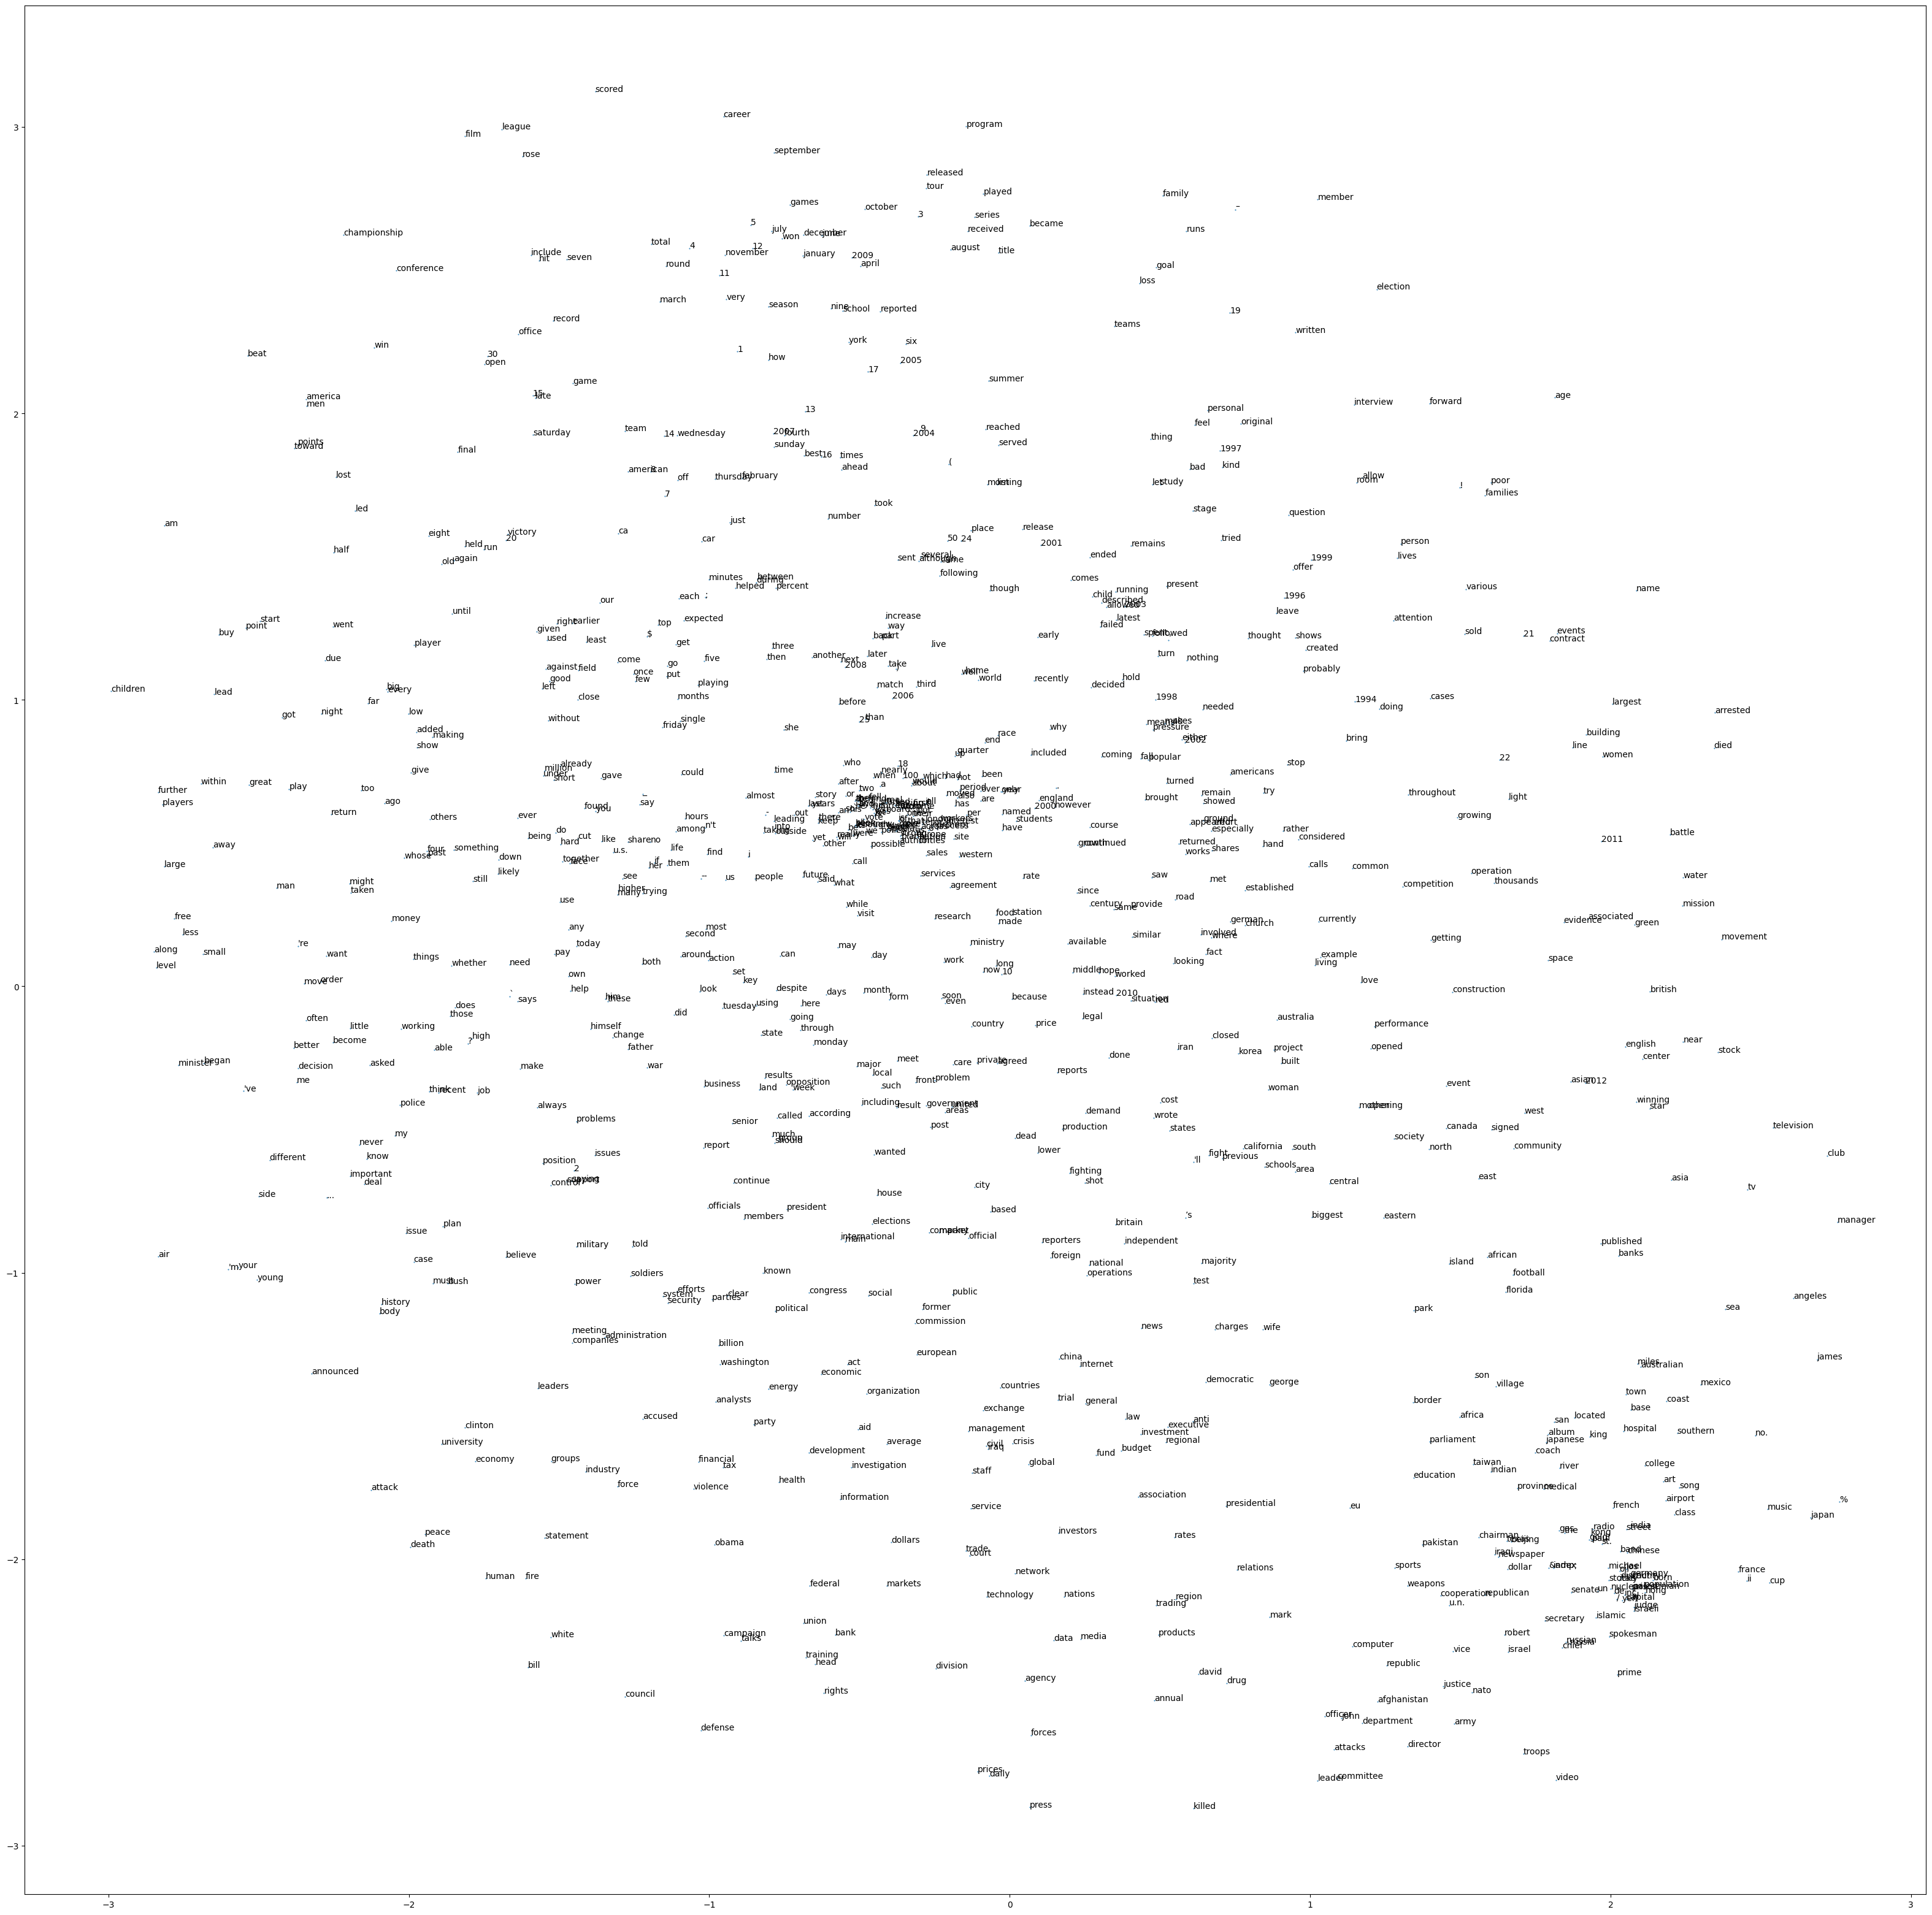

In [45]:
%matplotlib inline
import matplotlib.pyplot as plt

plt.figure(figsize=(40, 40))
axis = plt.gca()
np.set_printoptions(suppress=True)
plt.scatter(word_emb_tsne[:, 0], word_emb_tsne[:, 1], marker=".", s=1)

for idx in range(1000):
    plt.annotate(inv_index[idx],
                 xy=(word_emb_tsne[idx, 0], word_emb_tsne[idx, 1]),
                 xytext=(0, 0), textcoords='offset points')
plt.savefig("tsne.png")
plt.show()

### Using pre-trained embeddings in our model

We want to use these pre-trained embeddings for transfer learning. This process is rather similar than transfer learning in image recognition: the features learnt on words might help us bootstrap the learning process, and increase performance if we don't have enough training data.
- We initialize embedding matrix from the model with Glove embeddings:
 - take all words from our 20 Newgroup vocabulary, and look up their Glove embedding
 - place the Glove embedding at the corresponding index in the matrix
 - if the word is not in the Glove vocabulary, we only place zeros in the matrix
- We may fix these embeddings or fine-tune them

In [46]:
EMBEDDING_DIM = 100

embedding_bag = nn.EmbeddingBag(len(vocab), EMBEDDING_DIM)

i = 0

with torch.no_grad():
    for token in list(embeddings_index.keys()):
        if vocab[token] != 0:
            embedding_bag.weight[vocab[token]] = torch.from_numpy(get_emb(token)).float()
            i += 1

# Not placing zeros in the matrix, you might wanna try ?


print(f"Added {i} vectors to the pretrained embeddings.")

Added 21740 vectors to the pretrained embeddings.


### A model with pre-trained Embeddings

Average word embeddings pre-trained with Glove / Word2Vec usually works suprisingly well. However, when averaging more than `10-15` words, the resulting vector becomes too noisy and classification performance is degraded compared to supervisedly trained embeddings:

In [47]:
model = TextClassificationModel(
    vocab_size=len(vocab),
    embed_dim=EMBEDDING_DIM,
    num_class=N_CLASSES,
    pretrained_embedding=embedding_bag,
)

In [48]:
train_model(model, lr=1e-2, weight_decay=0., n_epochs=30)

  0%|          | 0/30 [00:00<?, ?it/s]

### Reality check

On small/medium datasets, simpler classification methods usually perform better, and are much more efficient to compute. Here are two resources to go further:
- Naive Bayes approach, using scikit-learn https://scikit-learn.org/stable/auto_examples/text/plot_document_classification_20newsgroups.html
- Alec Radford (OpenAI) gave a very interesting presentation, showing that you need a VERY large dataset to have real gains from GRU/LSTM in text classification https://www.slideshare.net/odsc/alec-radfordodsc-presentation

However, when looking at features, one can see that classification using simple methods isn't very robust, and won't generalize well to slightly different domains (e.g. forum posts => emails)